This is a program to generate a masks on a per-particle basis that are optimize to minimize the membrane for each particle. This is the preliminary program to identify the plane that bisects the two vesicles by searching for a minimum pixel intensity. It requires that all interfaces are aligned to a single 3d class (i.e. aligned to eachother). Then the steps are as follows:
Reorient to the origin xyz, by calculating and applying inverse rotations from the starfile. 

In [259]:
import numpy as np
import mrcfile
from scipy.ndimage import rotate, shift
import argparse
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm
from collections import defaultdict

Here we make the mask. 

In [153]:
def make_mask(
z_thickness, 
z_offset):
    rot = 0
    tilt = 0
    psi = 0
    
    #==== Make the mask
    box_size = 256
    mask = np.ones((box_size, box_size, box_size), dtype=np.uint8)
    
    #==== Cut out the center wedge
    z_center = (box_size - z_thickness) // 2
    z_start = z_center - z_offset
    z_end = z_start + z_thickness
    xy_start = z_center
    xy_end = xy_start + z_thickness
    
    mask[z_start:z_end, xy_start:xy_end, xy_start:xy_end] = 0
    
    #==== Perform rotations
    rot1 = rotate(mask, angle=-rot, axes=(1,2), reshape=False, order=1, mode='constant', cval=0.0)
    rot2 = rotate(rot1, angle=-tilt, axes=(0,2), reshape=False, order=1, mode='constant', cval=0.0)
    rot3 = rotate(rot2, angle=-psi, axes=(1,2), reshape=False, order=1, mode='constant', cval=0.0)\
    
    
    #==== Re-Binerize the mask
    binary_mask = (rot3 >= 0.5).astype(np.uint8)
    
    #==== Write out mask
    with mrcfile.new(f"./binary_mask_{z_thickness}_{z_offset}.mrc", overwrite=True) as out_mrc:
        out_mrc.set_data(binary_mask)
        out_mrc.voxel_size = (2.62, 2.62, 2.62)

In [154]:
with mrcfile.open('/Volumes/atbimac23-RAID/TomoPicking/Examples/job1866_25x40_vtm8_edge3/filtered/SV4_003_dff000001_wiener.mrc', permissive=True) as mrc:
        data = mrc.data.copy()
        
rot = 157.29
tilt = 126.929
psi = 173.776
x0, y0, z0 = 128, 128, 128
radius = 100

rot1 = rotate(data, angle=-rot, axes=(1,2), reshape=False, order=1, mode='constant', cval=0.0)
rot2 = rotate(rot1, angle=-tilt, axes=(0,2), reshape=False, order=1, mode='constant', cval=0.0)
rot3 = rotate(rot2, angle=-psi, axes=(1,2), reshape=False, order=1, mode='constant', cval=0.0)

arot, atilt, apsi = -139.89795, 128.307364, 177.726862

arot1 = rotate(data, angle=-arot, axes=(1,2), reshape=False, order=1, mode='constant', cval=0.0)
arot2 = rotate(arot1, angle=-atilt, axes=(0,2), reshape=False, order=1, mode='constant', cval=0.0)
arot3 = rotate(arot2, angle=-apsi, axes=(1,2), reshape=False, order=1, mode='constant', cval=0.0)

mrot, mtilt, mpsi = 0, 0, 90

mrot1 = rotate(data, angle=-arot, axes=(1,2), reshape=False, order=1, mode='constant', cval=0.0)
mrot2 = rotate(mrot1, angle=-atilt, axes=(0,2), reshape=False, order=1, mode='constant', cval=0.0)
mrot3 = rotate(mrot2, angle=-apsi, axes=(1,2), reshape=False, order=1, mode='constant', cval=0.0)

slice_2dx = rot3[z0 - radius:z0 + radius + 1, y0 - radius:y0 + radius + 1, x0]
slice_2dy = rot3[z0 - radius:z0 + radius + 1, y0, x0 - radius:x0 + radius + 1]
slice_2dz = rot3[z0, y0 - radius:y0 + radius + 1, x0 - radius:x0 + radius + 1]

mslice_2dx = mrot3[z0 - radius:z0 + radius + 1, y0 - radius:y0 + radius + 1, x0]
mslice_2dy = mrot3[z0 - radius:z0 + radius + 1, y0, x0 - radius:x0 + radius + 1]
mslice_2dz = mrot3[z0, y0 - radius:y0 + radius + 1, x0 - radius:x0 + radius + 1]

relion_rotation = R.from_euler('ZYZ', [rot, tilt, psi], degrees=True)

inverse_rotation = relion_rotation.inv()

chimera_angles = inverse_rotation.as_euler('XYZ', degrees=True)
print(rot)
print("ChimeraX rotation (XYZ extrinsic degrees):", chimera_angles)

157.29
ChimeraX rotation (XYZ extrinsic degrees): [-171.79203295   52.62398578 -167.57801872]


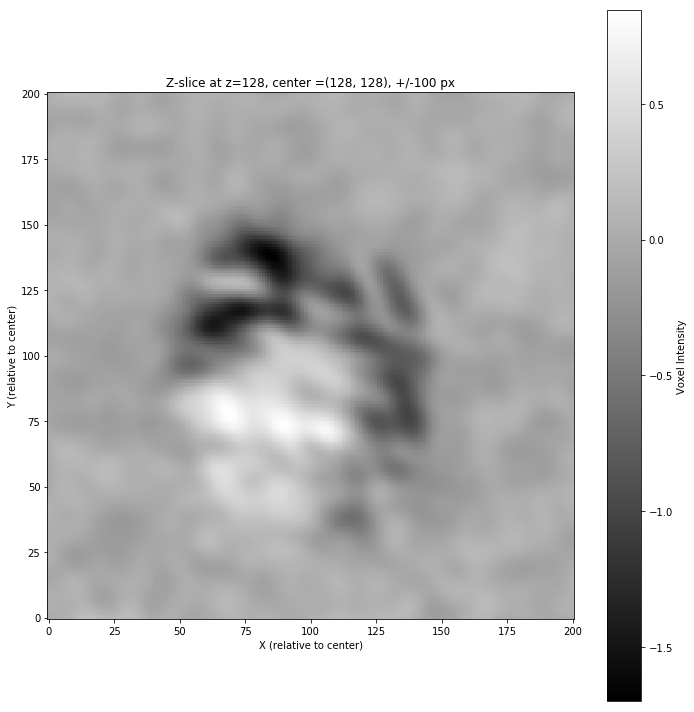

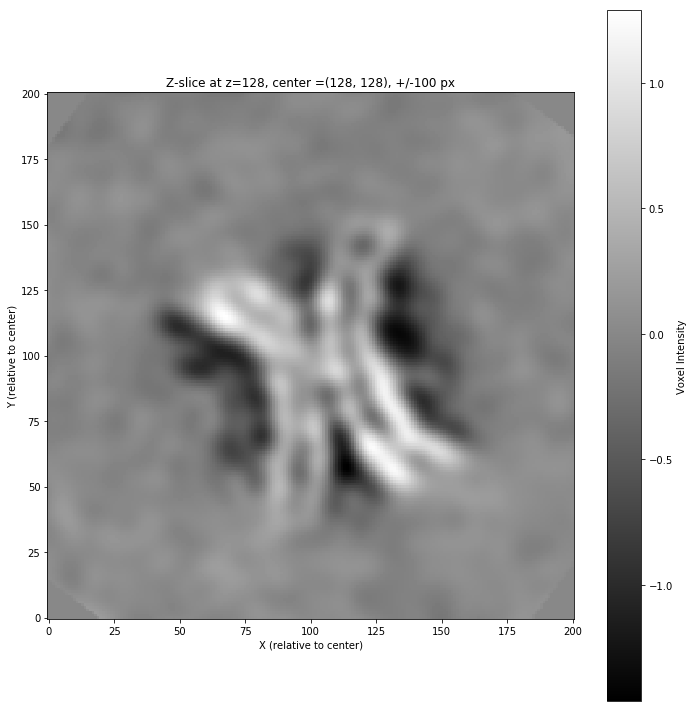

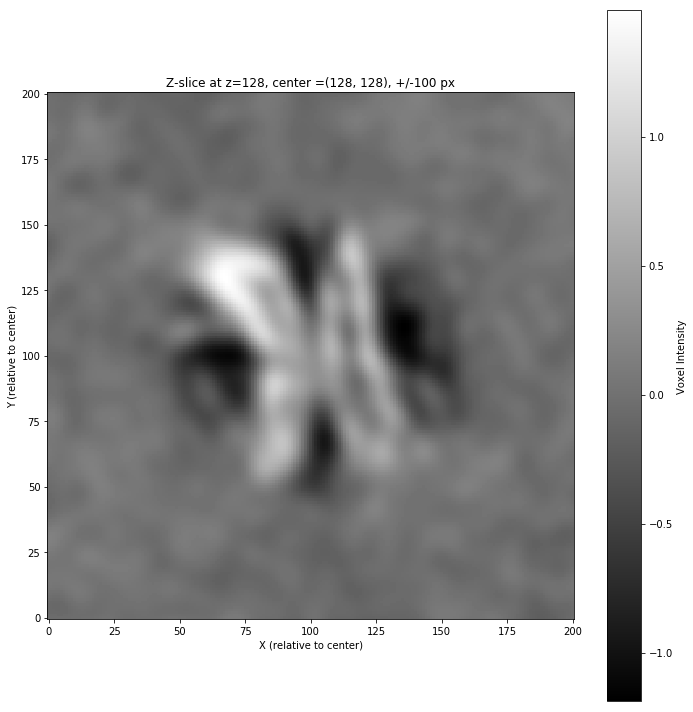

In [155]:
plt.figure(figsize=(10,10))
plt.imshow(slice_2dx, cmap='gray', origin='lower')
plt.title(f"Z-slice at z={z0}, center =({x0}, {y0}), +/-{radius} px")
plt.colorbar(label="Voxel Intensity")
plt.xlabel("X (relative to center)")
plt.ylabel("Y (relative to center)")
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(slice_2dy, cmap='gray', origin='lower')
plt.title(f"Z-slice at z={z0}, center =({x0}, {y0}), +/-{radius} px")
plt.colorbar(label="Voxel Intensity")
plt.xlabel("X (relative to center)")
plt.ylabel("Y (relative to center)")
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(slice_2dz, cmap='gray', origin='lower')
plt.title(f"Z-slice at z={z0}, center =({x0}, {y0}), +/-{radius} px")
plt.colorbar(label="Voxel Intensity")
plt.xlabel("X (relative to center)")
plt.ylabel("Y (relative to center)")
plt.tight_layout()
plt.show()

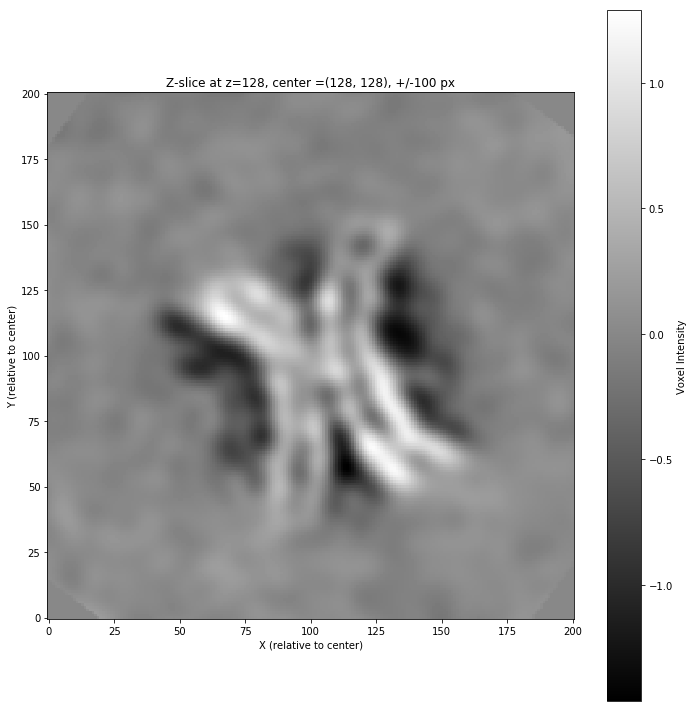

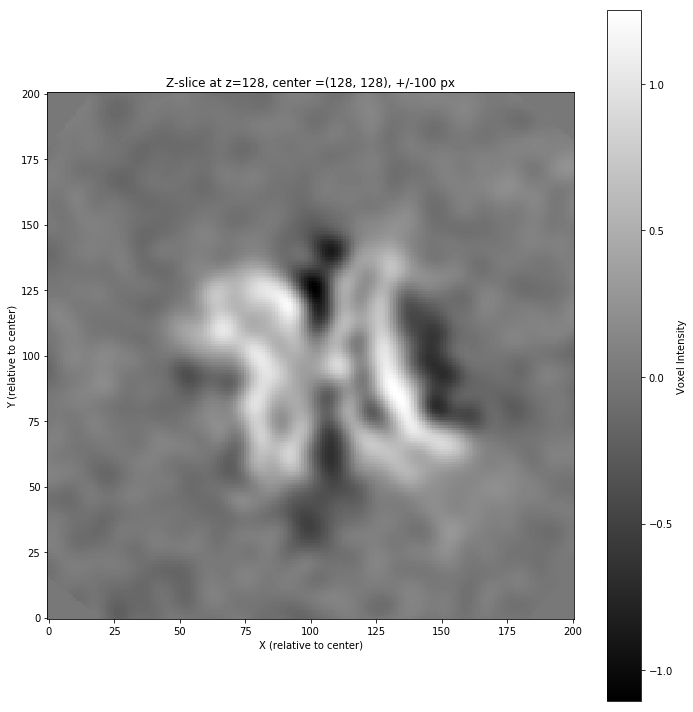

In [156]:
plt.figure(figsize=(10,10))
plt.imshow(slice_2dy, cmap='gray', origin='lower')
plt.title(f"Z-slice at z={z0}, center =({x0}, {y0}), +/-{radius} px")
plt.colorbar(label="Voxel Intensity")
plt.xlabel("X (relative to center)")
plt.ylabel("Y (relative to center)")
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(mslice_2dy, cmap='gray', origin='lower')
plt.title(f"Z-slice at z={z0}, center =({x0}, {y0}), +/-{radius} px")
plt.colorbar(label="Voxel Intensity")
plt.xlabel("X (relative to center)")
plt.ylabel("Y (relative to center)")
plt.tight_layout()
plt.show()

In [157]:
def generate_plane_mask(shape, normal, thickness=1):
    """
    Generate a binary mask selecting voxels near a plane with given normal.
    The plane passes through the center of the volume.
    """
    z_dim, y_dim, x_dim = shape
    cz, cy, cx = (z_dim // 2) + 4, y_dim // 2, x_dim // 2

    # Create coordinate grids
    zz, yy, xx = np.meshgrid(np.arange(z_dim), np.arange(y_dim), np.arange(x_dim), indexing='ij')

    # Shift coordinates to center
    zz = zz - cz
    yy = yy - cy
    xx = xx - cx

    # Compute signed distance to plane: D = n . r
    r = np.stack((zz, yy, xx), axis=0)
    d = normal[0]*r[0] + normal[1]*r[1] + normal[2]*r[2]

    # Create mask where distance to plane is within thickness
    mask = np.abs(d) < thickness
    return mask

def find_min_plane_direction(volume, theta_samples=30, phi_samples=60, thickness=1):
    
    # Search over all plane orientations to find one minimizing intensity sum.
 
    best_sum = np.inf
    best_angles = (0, 0)

    results = []

    for theta in tqdm(np.linspace(0, np.pi, theta_samples)):
        for phi in np.linspace(0, 2*np.pi, phi_samples):
            # Convert spherical to cartesian normal vector
            nx = np.sin(theta) * np.cos(phi)
            ny = np.sin(theta) * np.sin(phi)
            nz = np.cos(theta)
            normal = (nz, ny, nx)  # Note order: z, y, x for indexing

            # Generate mask near plane
            mask = generate_plane_mask(volume.shape, normal, thickness=thickness)

            # Sum voxel intensities
            sum_intensity = np.sum(volume[mask])

            results.append((theta, phi, sum_intensity))

            if sum_intensity < best_sum:
                best_sum = sum_intensity
                best_angles = (theta, phi)

    return best_angles, best_sum, results


In [158]:
def save_plane_mask_as_mrc(volume_shape, normal, thickness, output_path):
    """
    Save a binary mask highlighting a plane through the center of the volume.
    """
    mask = generate_plane_mask(volume_shape, normal, thickness=thickness)
    with mrcfile.new(output_path, overwrite=True) as mrc:
        mrc.set_data(mask.astype(np.uint8))
        mrc.voxel_size = (2.62, 2.62, 2.62)  # Set to match your tomogram voxel size

In [159]:
with mrcfile.open("/Volumes/atbimac23-RAID/TomoPicking/Examples/job1866_25x40_vtm8_edge3/filtered/SV4_003_dff000001_wiener.mrc", permissive=True) as mrc:
    vol = mrc.data.astype(np.float32)

theta_phi, min_sum, all_results = find_min_plane_direction(vol, thickness=2)

print("Best plane angles (theta, phi):", theta_phi)
print("Minimum sum intensity:", min_sum)

theta, phi = theta_phi
nz = np.cos(theta)
ny = np.sin(theta) * np.sin(phi)
nx = np.sin(theta) * np.cos(phi)
normal = (nz, ny, nx)  # z, y, x ordering for voxel space

save_plane_mask_as_mrc(vol.shape, normal, thickness=2, output_path='best_plane_mask_p4.mrc')


100%|██████████| 30/30 [14:00<00:00, 28.25s/it]


Best plane angles (theta, phi): (2.2749464043236434, 0.10649466622338281)
Minimum sum intensity: -27585.605


In [233]:
def measure_gap_along_normal(volume, center=None, window=5, threshold=0.3, max_depth=None, min_gap_distance=0):
    if center is None:
        center = np.array(volume.shape) // 2
    cz, cy, cx = center

    if max_depth is None:
        max_depth = volume.shape[0] // 2

    distances = []
    points = []

    for dy in range(-window, window + 1):
        for dx in range(-window, window + 1):
            y = cy + dy
            x = cx + dx

            if not (0 <= y < volume.shape[1] and 0 <= x < volume.shape[2]):
                continue

            top_hit = None
            bottom_hit = None

            for dz in range(1, max_depth):
                zp = cz + dz
                zn = cz - dz

                if zp < volume.shape[0] and top_hit is None:
                    if volume[zp, y, x] > threshold:
                        top_hit = dz

                if zn >= 0 and bottom_hit is None:
                    if volume[zn, y, x] > threshold:
                        bottom_hit = dz

                if top_hit is not None and bottom_hit is not None:
                    break

            if top_hit is not None and bottom_hit is not None:
                gap = top_hit + bottom_hit
                if gap >= min_gap_distance:
                    distances.append(gap)
                    points.append((x, y))

    return distances, points


(-0.6473862847818276, 0.08101286146767595, 0.7578442548130859)


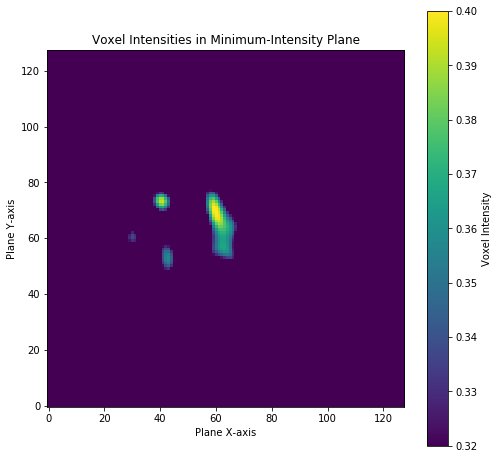

In [220]:
#Need to convert the best_angles found for the plane with minimum intensity from spherical to cartesian.
theta, phi = theta_phi

nx = np.sin(theta) * np.cos(phi)
ny = np.sin(theta) * np.sin(phi)
nz = np.cos(theta)

normal = (nz, ny, nx)  # z, y, x order for volumetric indexing
print(normal)


def sample_plane_intensity(volume, normal, plane_size=100, spacing=1.0, thickness=1):
    """
    Sample voxel intensities in a 2D grid along a given plane through the volume center.
    Returns a 2D array of sampled intensities.
    """
    z_dim, y_dim, x_dim = volume.shape
    cz, cy, cx = np.array(volume.shape) // 2
    center = np.array([cz, cy, cx])

    # Create two orthogonal in-plane vectors (span the plane)
    normal = np.array(normal) / np.linalg.norm(normal)
    if np.allclose(normal, [1, 0, 0]):
        v1 = np.cross(normal, [0, 1, 0])
    else:
        v1 = np.cross(normal, [1, 0, 0])
    v1 = v1 / np.linalg.norm(v1)
    v2 = np.cross(normal, v1)
    v2 = v2 / np.linalg.norm(v2)

    # Create a grid in the plane
    coords = []
    for i in range(-plane_size//2, plane_size//2):
        for j in range(-plane_size//2, plane_size//2):
            point = center + spacing * (i * v1 + j * v2)
            coords.append(point)

    coords = np.array(coords).T  # shape (3, N)
    intensities = map_coordinates(volume, coords, order=1, mode='nearest')
    return intensities.reshape((plane_size, plane_size))

# --- Use the function ---
# Example: assume `vol` is your 3D volume and `normal` is the plane normal
plane_image = sample_plane_intensity(vol, normal=normal, plane_size=128, spacing=1.0)

# --- Plot as heatmap ---
plt.figure(figsize=(8, 8))
plt.imshow(plane_image, cmap='viridis', origin='lower', vmin=.32, vmax=.4)
plt.colorbar(label="Voxel Intensity")
plt.title("Voxel Intensities in Minimum-Intensity Plane")
plt.xlabel("Plane X-axis")
plt.ylabel("Plane Y-axis")
plt.grid(False)
plt.show()


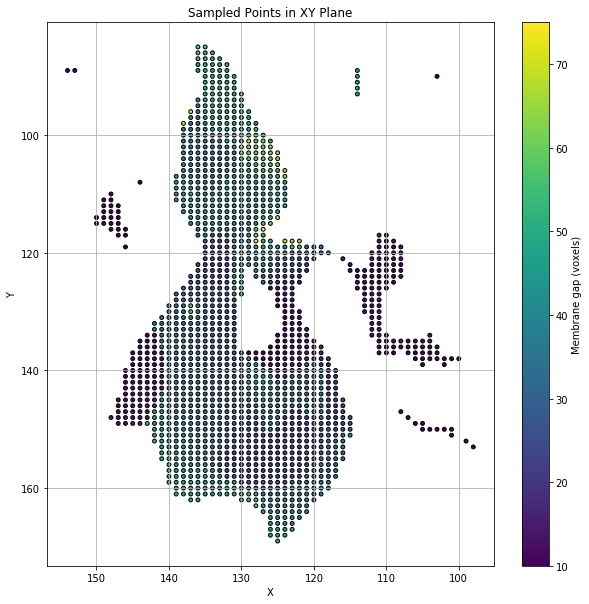

In [252]:
import matplotlib.pyplot as plt

# Run the measurement
center = (np.array(vol.shape) // 2 ) + 2
distances, points = measure_gap_along_normal(vol, center=center, window=50, threshold=.4, min_gap_distance=10)

# Separate x and y for plotting
x_coords, y_coords = zip(*points)

# Plot the sampled points in the plane
plt.figure(figsize=(10, 10))
plt.scatter(x_coords, y_coords, c=distances, cmap='viridis', s=15, edgecolor='k')
plt.colorbar(label='Membrane gap (voxels)')
plt.title("Sampled Points in XY Plane")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().invert_xaxis()  # Match image coordinates
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


In [253]:
# Assume `rotated_volume` is aligned with the membrane plane in XY
center = np.array(vol.shape) // 2

distances, points = measure_gap_along_normal(vol, center=center, window=50, threshold=0.4, min_gap_distance=10)
print("Avg membrane gap:", np.mean(distances))


Avg membrane gap: 31.471812080536914


Group gap distances into concentric rings and compute average per ring.

   Parameters:
        distances: list of membrane gap sizes
        points: list of (x, y) coordinates
        center: (x0, y0) center point for radial distance
        bin_size: width of each radial ring
        max_radius: maximum radius to consider

   Returns:
        bin_centers: list of radial distances (bin centers)
        avg_gaps: list of average gap size in each radial bin

In [256]:
def compute_radial_gap_profile(distances, points, center=(128, 128), bin_size=5, max_radius=50):
    
    # Create bins
    radial_bins = defaultdict(list)

    cx, cy = center
    for (x, y), gap in zip(points, distances):
        r = np.sqrt((x - cx)**2 + (y - cy)**2)
        if r <= max_radius:
            bin_index = int(r // bin_size)
            radial_bins[bin_index].append(gap)

    # Compute averages
    bin_centers = []
    avg_gaps = []
    for bin_index in sorted(radial_bins.keys()):
        gaps = radial_bins[bin_index]
        if gaps:
            bin_center = bin_index * bin_size + bin_size / 2
            bin_centers.append(bin_center)
            avg_gaps.append(np.mean(gaps))

    return bin_centers, avg_gaps


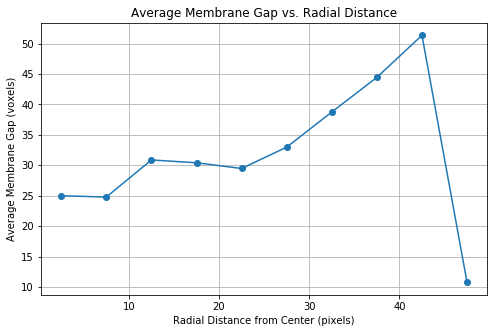

In [262]:
bin_centers, avg_gaps = compute_radial_gap_profile(
    distances, points, center=(128, 128), bin_size=5, max_radius=75
)

# === Plot ===
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, avg_gaps, marker='o')
plt.title("Average Membrane Gap vs. Radial Distance")
plt.xlabel("Radial Distance from Center (pixels)")
plt.ylabel("Average Membrane Gap (voxels)")
plt.grid(True)
plt.show()

In [ ]:
import xml.etree.ElementTree as ET

def indent_xml(elem, level=0):
    i = "\n" + level * "  "
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = i + "  "
        for child in elem:
            indent_xml(child, level + 1)
        if not elem.tail or not elem.tail.strip():
            elem.tail = i
    else:
        if level and (not elem.tail or not elem.tail.strip()):
            elem.tail = i

def export_cmm(points, distances, center_z, voxel_size=2.62, out_file="membrane_gap_markers.cmm"):
    root = ET.Element("marker_set", {'name': "Membrane_Gap_Markers", 'href': ""})
    
    marker_id = 0
    for (x, y), dist in zip(points, distances):
        z_top = center_z + dist / 2
        z_bot = center_z - dist / 2
        
        for z_val in [z_bot, z_top]:
            marker = ET.SubElement(root, "marker", {'id': str(marker_id)})
            coord = f"{x * voxel_size:.3f} {y * voxel_size:.3f} {z_val * voxel_size:.3f}"
            ET.SubElement(marker, "point").text = coord
            ET.SubElement(marker, "radius").text = "10.0"
            ET.SubElement(marker, "color").text = "1.0 0.0 0.0"  # Red
            marker_id += 1

    tree = ET.ElementTree(root)
    indent_xml(root)
    tree.write(out_file, encoding="UTF-8", xml_declaration=True)


In [164]:
center = np.array(vol.shape) // 2
distances, points = measure_gap_along_normal(vol, center=center, window=5, threshold=0.5)

export_cmm(
    points=points,
    distances=distances,
    center_z=center[0],
    voxel_size=2.62,  # Adjust to your tomogram voxel size
    out_file="membrane_gap_markers.cmm"
)


In [165]:
print("Number of points:", len(points))
print("Sample point:", points[2])
print("Sample distance:", distances[0])


Number of points: 121
Sample point: (125, 123)
Sample distance: 30


In [166]:
#import numpy as np
#from scipy.ndimage import map_coordinates

def sample_plane_intensities(volume, plane_normal, center=None, size=20, spacing=1.0):
    """
    Sample pixel intensities in a plane of a 3D volume.
    
    Args:
        volume (np.ndarray): 3D array (Z, Y, X)
        plane_normal (np.ndarray): Normal vector of the plane (3,)
        center (np.ndarray): Center point in the volume (3,), defaults to volume center
        size (int): Half-width of the grid in number of points
        spacing (float): Distance between points in voxels

    Returns:
        grid_values (np.ndarray): 2D array of sampled intensities
    """

    # Center of the volume by default
    if center is None:
        center = np.array(volume.shape) / 2

    # Normalize the plane normal
    normal = plane_normal / np.linalg.norm(plane_normal)

    # Create two orthonormal basis vectors in the plane
    if np.allclose(normal, [0, 0, 1]):
        u = np.array([1, 0, 0])
    else:
        u = np.cross(normal, [0, 0, 1])
        u /= np.linalg.norm(u)

    v = np.cross(normal, u)

    # Create 2D grid in (u,v) space
    grid_range = np.arange(-size, size+1) * spacing
    uu, vv = np.meshgrid(grid_range, grid_range, indexing='ij')

    # Compute 3D coordinates for each point in the grid
    coords = center[:, None, None] + uu[None, :, :] * u[:, None, None] + vv[None, :, :] * v[:, None, None]

    # Rearrange coords for map_coordinates: shape should be (3, N)
    coords_flat = coords.reshape(3, -1)

    # Interpolate voxel values
    sampled_values = map_coordinates(volume, coords_flat, order=1, mode='nearest')
    
    # Reshape back to 2D grid
    return sampled_values.reshape(uu.shape)


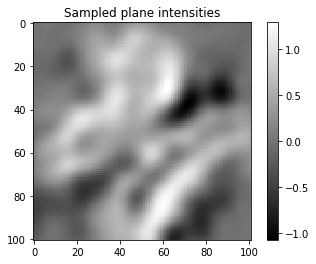

In [167]:
# Define a plane normal (e.g., based on Euler angles if you have them)
plane_normal = np.array([0, 1, 1])

# Sample intensities in the plane
plane_vals = sample_plane_intensities(vol, plane_normal, center=np.array(vol.shape)/2, size=50, spacing=1.0)

# Display or analyze
import matplotlib.pyplot as plt
plt.imshow(plane_vals, cmap='gray')
plt.title("Sampled plane intensities")
plt.colorbar()
plt.show()


In [170]:
# Extract voxel values within the mask
masked_voxels = vol[mask]

# Print some stats
print(f"Number of voxels in mask: {masked_voxels.size}")
print(f"Min intensity: {masked_voxels.min()}")
print(f"Max intensity: {masked_voxels.max()}")
print(f"Mean intensity: {masked_voxels.mean()}")
print(f"Std deviation: {masked_voxels.std()}")


Number of voxels in mask: 172953
Min intensity: -1.5042506456375122
Max intensity: 0.5666587352752686
Mean intensity: -0.08157864212989807
Std deviation: 0.22302620112895966


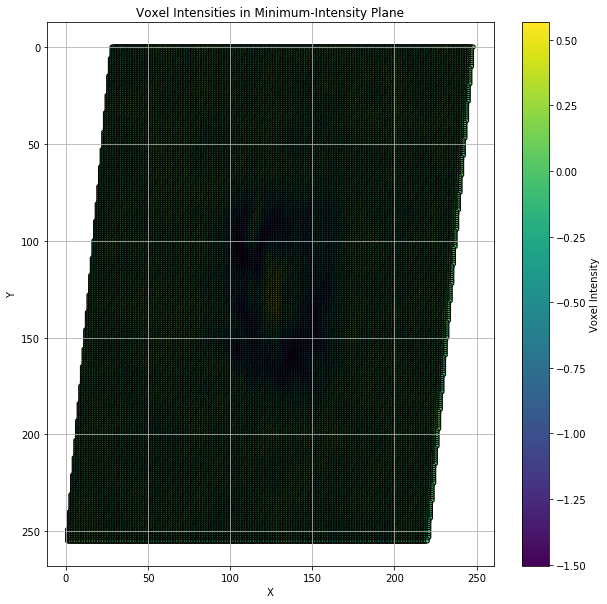

In [169]:
import matplotlib.pyplot as plt

# Create mask for your best normal direction
normal = (nz, ny, nx)  # obtained from `find_min_plane_direction(...)`
mask = generate_plane_mask(vol.shape, normal, thickness=1)

# Get indices of the voxels within the mask
z_idx, y_idx, x_idx = np.where(mask)

# Get corresponding voxel intensities
intensities = vol[z_idx, y_idx, x_idx]

# Plot: project onto XY plane
plt.figure(figsize=(10, 10))
plt.scatter(x_idx, y_idx, c=intensities, cmap='viridis', s=15, edgecolor='k')
plt.colorbar(label='Voxel Intensity')
plt.title("Voxel Intensities in Minimum-Intensity Plane")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


    Extract to an MRC

In [185]:
# Transpose the sampled slice to match XY convention
corrected_slice = np.transpose(plane_image)

# Or use this if visually flipped:
corrected_slice = np.flip(np.transpose(plane_image), axis=0)

plane_3d = corrected_slice[np.newaxis, :, :].astype(np.float32)

mrcfile.write('corrected_min_plane_slice.mrc', plane_3d, voxel_size=2.62, overwrite=True)


In [182]:
!pwd

/Users/leitzj/Documents/GitHub/Jeremy_Scripts/Cryo_Leitz
